In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

2025-03-28 08:14:03.502883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743149643.514905   63838 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743149643.518613   63838 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743149643.527948   63838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743149643.527960   63838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743149643.527962   63838 computation_placer.cc:177] computation placer alr

In [6]:
def load_data(filename):
    images, images_test = list(), list()
    spots, spots_test = list(), list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        for i, slide_name in enumerate(train_images.keys()):
            image = np.array(train_images[slide_name])
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name])).assign(slide = i))
    

        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = np.array(test_images[sample])
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images_test.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots_test.append(pd.DataFrame(np.array(test_spots[sample])).assign(slide = 0))
        
    images = tf.constant(images)
    df_spots = pd.concat(spots)
    images_test = tf.constant(images_test)
    df_spots_test = pd.concat(spots_test)
    return images, df_spots, images_test, df_spots_test

images, df_spots, images_test, df_spots_test = load_data("data/elucidata_ai_challenge_data.h5")
targets = [i for i in df_spots.columns if i.startswith('C')]

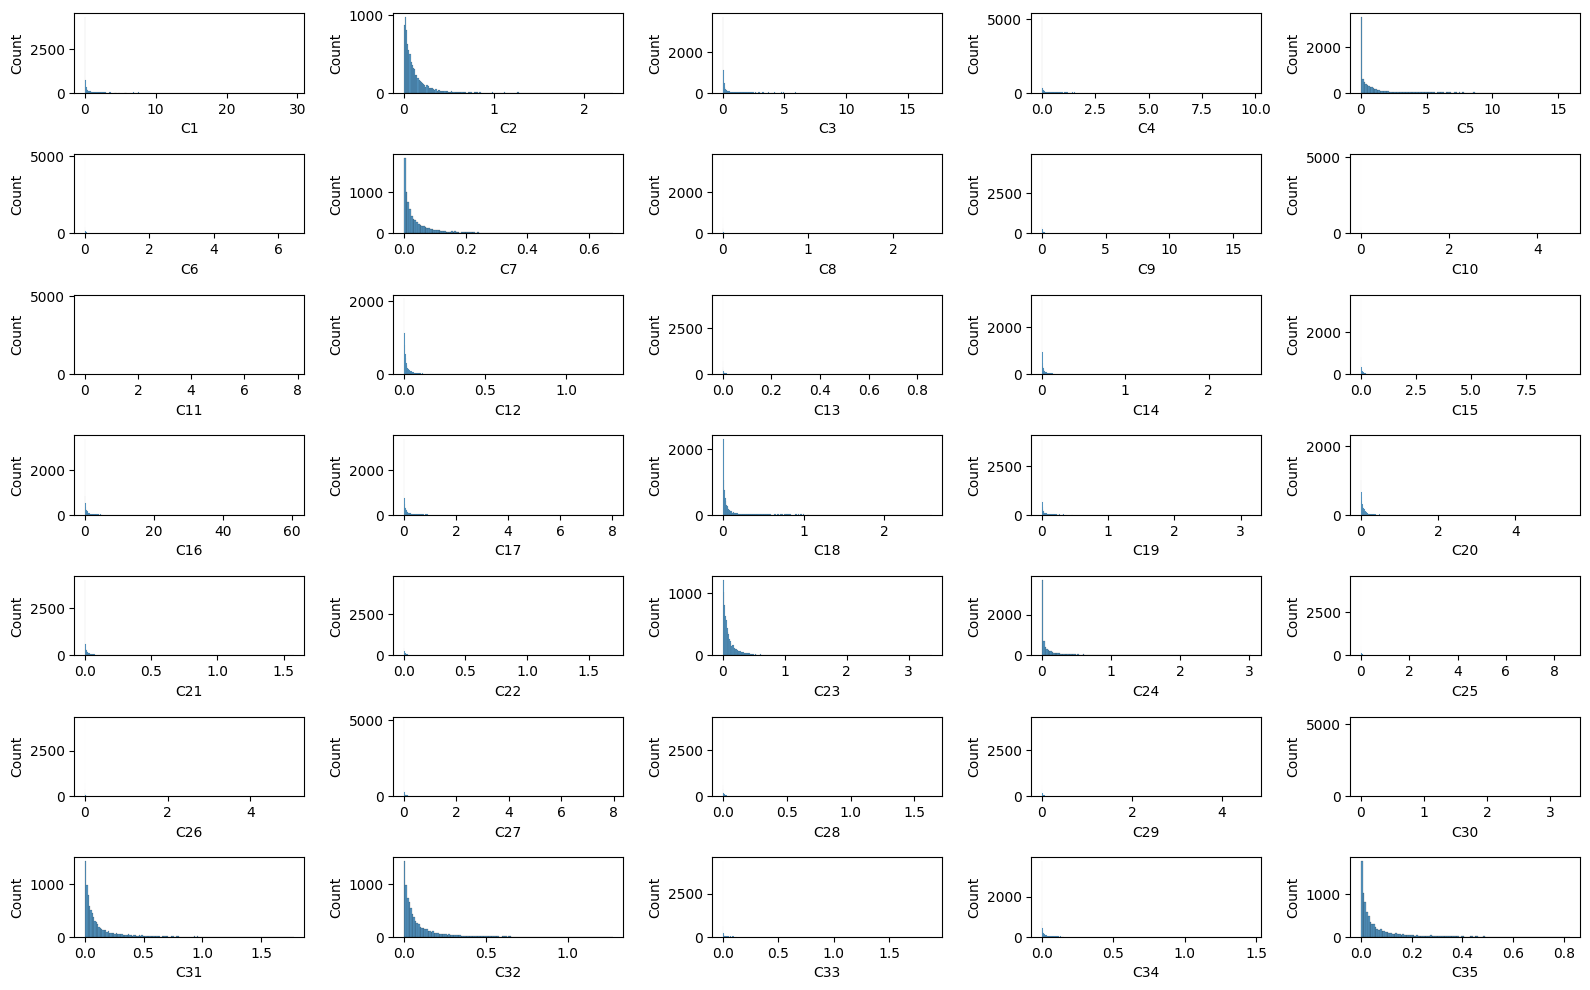

In [98]:
fig, axes = plt.subplots(7, 5, figsize = (16, 10))
for i, ax in zip(targets, axes.flatten()):
    sns.histplot(df_spots, x = i, ax = ax)
plt.tight_layout()
plt.show()

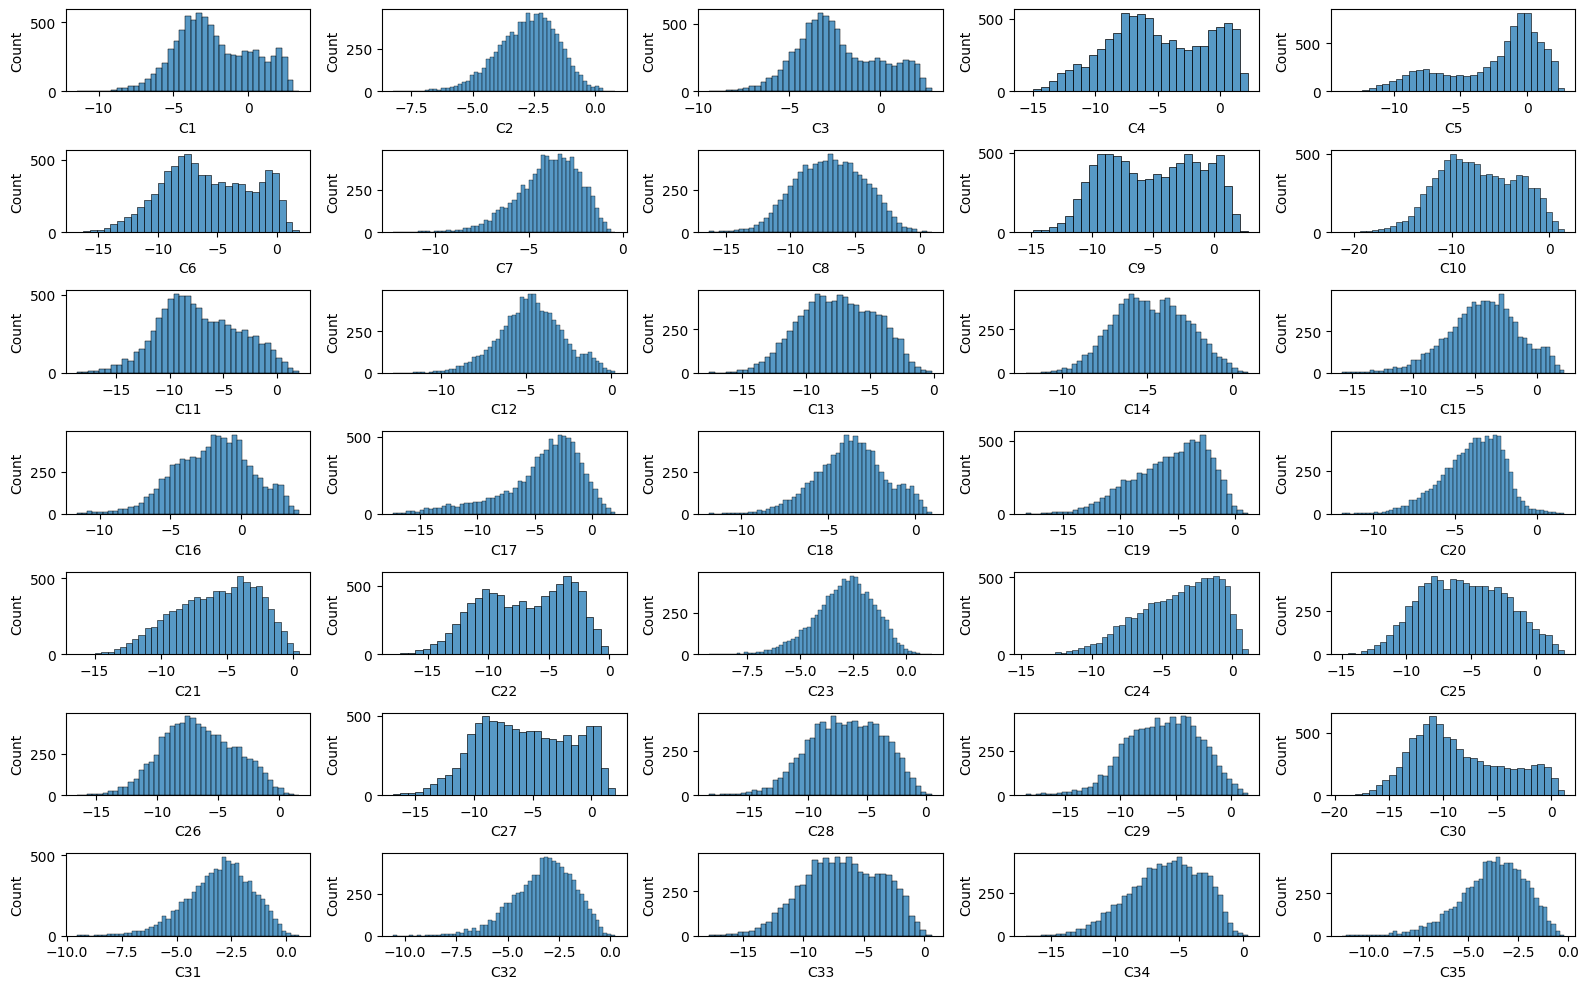

In [99]:
fig, axes = plt.subplots(7, 5, figsize = (16, 10))
for i, ax in zip(targets, axes.flatten()):
    sns.histplot(x = np.log(df_spots[i]), ax = ax)
plt.tight_layout()
plt.show()

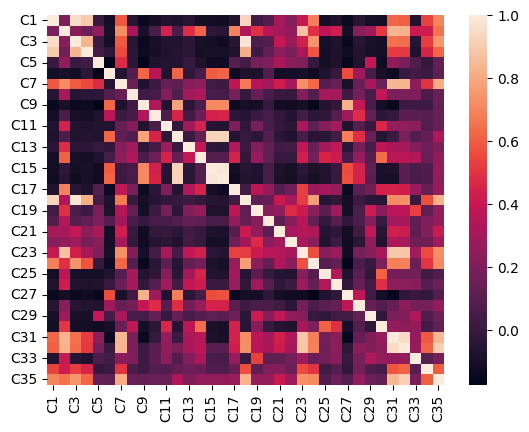

In [102]:
sns.heatmap(
    df_spots[targets].corr()
)
plt.show()

In [103]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_spots[targets])

PCA()

In [105]:
pca.explained_variance_ratio_.cumsum()

array([0.59997605, 0.87589215, 0.94406288, 0.9587159 , 0.96959785,
       0.97682391, 0.98161951, 0.98541462, 0.98854434, 0.99071653,
       0.99272638, 0.99413127, 0.99521954, 0.99612862, 0.99691124,
       0.99751865, 0.99795981, 0.99833952, 0.99868332, 0.99900519,
       0.99919032, 0.99936292, 0.99949482, 0.9995885 , 0.9996775 ,
       0.99975433, 0.99981318, 0.9998685 , 0.9999088 , 0.99993333,
       0.99995296, 0.99997006, 0.99998251, 0.99999278, 1.        ])

<Axes: >

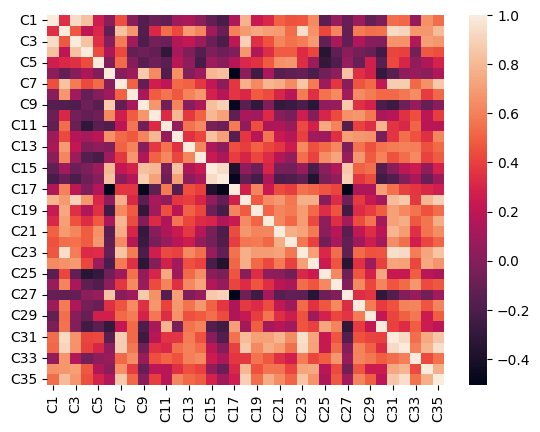

In [106]:
sns.heatmap(
    df_spots[targets].corr(method='spearman')
)

In [14]:
img_width = 224
img_height = 224
def make_img_proc_info(df, img_with, img_height):
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['x'] + img_width // 2,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['y'] + img_height // 2,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )
df_spots = make_img_proc_info(df_spots, img_width, img_height)
df_spots_test = make_img_proc_info(df_spots_test, img_width, img_height)

In [10]:
def create_tf_ds(df):
    if (pd.Series(targets).isin(df.columns)).all():
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, np.log(df[targets]))
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })

def proc_images(X):
    return tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=1
    )

2025-03-28 08:28:34.615265: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


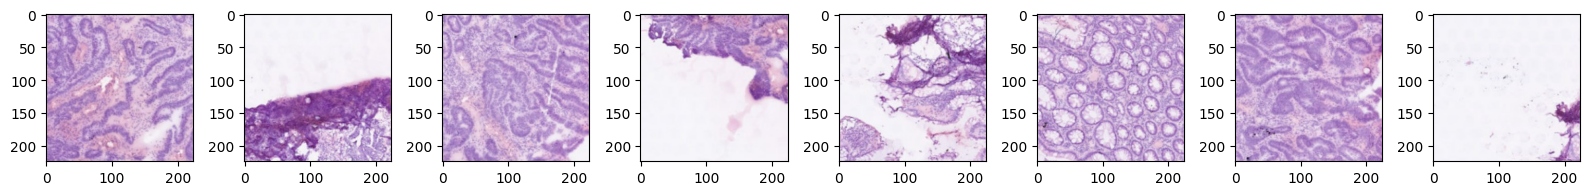

In [15]:
ds_train = create_tf_ds(df_spots)
fig, axes = plt.subplots(1, 8, figsize = (16, 3))
for X, Y in ds_train.map(lambda X, Y: (proc_images(X), Y)).batch(8).take(1):
    for i, ax in zip(range(8), axes.flatten()):
        ax.imshow(X[i])
plt.tight_layout()
plt.show()

2025-03-28 08:30:31.877083: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


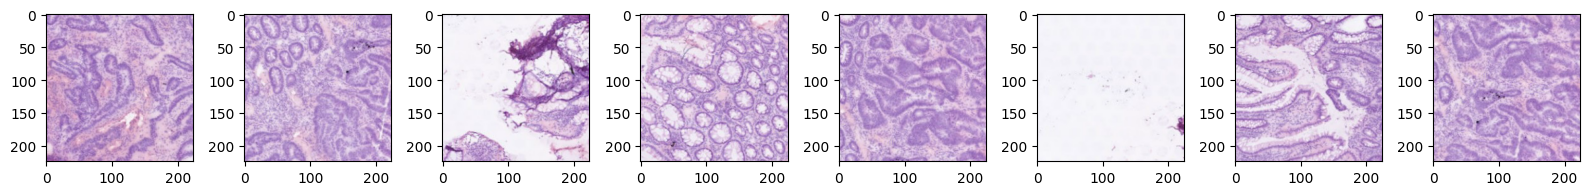

In [17]:
ds_test = create_tf_ds(df_spots_test)
fig, axes = plt.subplots(1, 8, figsize = (16, 3))
for X in ds_test.map(lambda X: proc_images(X)).batch(8).take(1):
    for i, ax in zip(range(8), axes.flatten()):
        ax.imshow(X[i])
plt.tight_layout()
plt.show()